In [1]:
#!/usr/bin/env python
# coding: utf-8

import xarray as xr
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import yaml
import pickle as pkl
import subprocess
from keras.regularizers import L1L2


from src.data_preparation import mdl_dataset

from src.modelling import mdl_input_dico  # input variables class
from src.modelling import mdl_params  # parameters class
from src.modelling import mdl_history

from src.modelling import model_cnn
# from src.modelling import super_model_dl

from src.visualization import visualize_pca
from src.visualization import mdl_introspect
from src.visualization import mdl_ypred_PCA

from src.utils import reload_config
from src.utils import tardisml_utils

2023-02-08 13:47:56.870738: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-08 13:48:00.228680: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-08 13:48:00.228773: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-08 13:48:33.429981: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
# add argument to pass config file
import sys
narg = len(sys.argv)  # number of arguments passed
if narg > 1:
    file_config = sys.argv[1]
else:
    file_config = '../config/data_proc_full.yaml'

In [3]:
file_config = '../config/config_to_jobs/config_CNN_no_bias_0wk.yaml'

In [4]:
rootdir = tardisml_utils.get_rootdir()
# file_config = '../config/data_proc_full.yaml'
conf = reload_config.Config(file_config, rootdir=rootdir, verbose=1)

Config file found: ../config/config_to_jobs/config_CNN_no_bias_0wk.yaml
PCA results in: /nird/projects/nird/NS2993K/Leo/results/pca_i100-550_j300-629
Config file updated 'pca_dir': ../config/config_to_jobs/config_CNN_no_bias_0wk.yaml
Results in: /nird/projects/nird/NS2993K/Leo/results/cnn_230208-134925
Folder created

Subfolder created: /nird/projects/nird/NS2993K/Leo/results/cnn_230208-134925/ml/
Subfolder created: /nird/projects/nird/NS2993K/Leo/results/cnn_230208-134925/figures/
Config file updated 'results_dir': ../config/config_to_jobs/config_CNN_no_bias_0wk.yaml
Config folders updated.
Config copied to: /nird/projects/nird/NS2993K/Leo/results/cnn_230208-134925
Config file found: /nird/projects/nird/NS2993K/Leo/results/cnn_230208-134925/config_CNN_no_bias_0wk.yaml
Default config file is now the copied following one:
/nird/projects/nird/NS2993K/Leo/results/cnn_230208-134925/config_CNN_no_bias_0wk.yaml


In [5]:
# ---------------------------------------------------
#                 Defining parameters
# ---------------------------------------------------

H = [0,7,14,21,28, 35, 42, 49, 56, 63, 70, 77]

new_hist = mdl_history.History(conf)
new_hist.set_zeros()
new_hist.set_SIT_history('keras', H)

var_to_keep = ['SITf t+0', 'sisnthick t+0', '2T t+0', '2T t+8', 'MSL t+0', 'TP t+0', 'TP t+8', 'siconc t+0']

In [6]:
# ---------------------------------------------------
#                 Loading data
# ---------------------------------------------------
# print('Loading data...')
#ds = mdl_dataset.Dataset(conf, setup='no_bias', history=new_hist, var_to_keep=var_to_keep)
ds = mdl_dataset.Dataset(conf, setup=conf.setup, history=new_hist, var_to_keep=var_to_keep)


# ds_nn = [ds.dataset, 'change le format stp']
# ntvt = (ds.ntrain, ds.nval, ds.ntest)

regularizers = [L1L2(l1=0.01, l2=0)] # , L1L2(l1=0, l2=0.01), L1L2(l1=0.1, l2=0.1)]


Initialisation dataset...
Loading data...
	Retrieve siconc
	Retrieve sisnthick
	Retrieve zos
	Retrieve vxsi
	Retrieve vysi
Loading forcing values...
Loading pca...
Apply land/ocean mask...
Retrieve PCs and EOFs
New variable selection:
  ['SITf t+0 PC0' 'SITf t+0 PC1' 'SITf t+0 PC2' 'SITf t+0 PC3'
 'SITf t+0 PC4' 'SITf t+0 PC5' 'SITf t+0 PC6' 'SITf t+0 PC7'
 'sisnthick t+0 PC0' 'sisnthick t+0 PC1' 'sisnthick t+0 PC2'
 'sisnthick t+0 PC3' '2T t+0 PC0' '2T t+0 PC1' '2T t+0 PC2' '2T t+0 PC3'
 'MSL t+0 PC0' 'MSL t+0 PC1' 'MSL t+0 PC2' 'MSL t+0 PC3' 'TP t+0 PC0'
 'TP t+0 PC1' 'TP t+0 PC2' 'TP t+0 PC3' 'siconc t+0 PC0' 'siconc t+0 PC1'
 'siconc t+0 PC2' 'siconc t+0 PC3']
Variables updated: do not forget to execute self.format_for_dl() if Deep Learning
Size of the training set:    1909 days
Size of the validation set:   440 days
Size of the test set:         588 days
Config file updated 'ntrain': /nird/projects/nird/NS2993K/Leo/results/cnn_230208-134925/config_CNN_no_bias_0wk.yaml
Config file

In [8]:
from importlib import reload

In [164]:
reload(model_cnn)

<module 'src.modelling.model_cnn' from '/cluster/home/leoede/tardis/tardis-ml/src/modelling/model_cnn.py'>

In [165]:
# ---------------------------------------------------
#                 Building cnn
# ---------------------------------------------------

n_components = ds.config.n_comp['tp']

suffixe = ''  # useless ?
reg = regularizers[0]

    
m4 = model_cnn.ModelCNN(ds, ds.dataset['Xtrain'].shape[1], ds.dataset['Xtrain'].shape[2], reg=reg, rootdir=ds.config.rootdir, ml_dir=ds.config.ml_dir, fig_dir=ds.config.fig_dir)
m4.compile_models(npca=n_components, name='CNN_uncert')  # name

# dbug - should be good
# m4.print_summary()
# import pdb; pdb.set_trace()

input change depending on model !!
Compiled !
Compiled !
Compiled !
Compiled !
Compiled !
Compiled !
Compiled !
Compiled !


In [149]:
m4.models['pc0'].summary()

Model: "model_114"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_119 (InputLayer)         [(None, 12, 28)]     0           []                               
                                                                                                  
 conv1d_225 (Conv1D)            (None, 12, 256)      36096       ['input_119[0][0]']              
                                                                                                  
 max_pooling1d_117 (MaxPooling1  (None, 3, 256)      0           ['conv1d_225[0][0]']             
 D)                                                                                               
                                                                                                  
 dropout_117 (Dropout)          (None, 3, 256)       0           ['max_pooling1d_117[0][0]

In [21]:
m4.epochs
m4.batch_size

4

In [26]:
ds.dataset['Xtrain'].shape

(1859, 12, 28)

In [28]:
ds.dataset['ytrain'][:,0:2].shape

(1859, 2)

In [34]:
type(ds.dataset['ytrain'][:,0:2])

numpy.ndarray

In [90]:
        import tensorflow_probability as tfp


In [91]:
mean_pred, std_pred = ds.dataset['ytrain'][...,0], ds.dataset['ytrain'][...,1]

In [93]:
norm_dist = tfp.distributions.Normal(loc=mean_pred, scale=std_pred)

In [157]:
loss = norm_dist . log_prob(ds.dataset['ytrain'][:,0])

In [158]:
loss

<tf.Tensor: shape=(1859,), dtype=float32, numpy=
array([       nan,        nan,        nan, ..., -5.074899 , -5.1040297,
       -5.118217 ], dtype=float32)>

In [101]:
import tensorflow as tf

In [103]:
loss = tf.reduce_mean(loss , -1)

In [108]:
loss

<tf.Tensor: shape=(), dtype=float32, numpy=nan>

In [166]:
hi = m4.models['pc0'].fit(ds.dataset['Xtrain'], ds.dataset['ytrain'][:,0:2], epochs=100, batch_size=4, 
                     verbose=1, validation_data=(ds.dataset['Xval'], ds.dataset['yval'][:,0:2]), shuffle=True)

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: [Errno 28] No space left on device: '/tmp/__autograph_generated_file5h5fa26m.py'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: [Errno 28] No space left on device: '/tmp/__autograph_generated_file5h5fa26m.py'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
prout
prout
prout
prout
prout
prout
prout
prout


InvalidArgumentError: Graph execution error:

Detected at node 'gradient_tape/loss_mle/BroadcastGradientArgs' defined at (most recent call last):
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 367, in dispatch_shell
      await result
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_10565/2984542143.py", line 1, in <cell line: 1>
      hi = m4.models['pc0'].fit(ds.dataset['Xtrain'], ds.dataset['ytrain'][:,0:2], epochs=100, batch_size=4,
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 526, in minimize
      grads_and_vars = self.compute_gradients(loss, var_list, tape)
    File "/cluster/home/leoede/.conda/envs/tardis-env/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 259, in compute_gradients
      grads = tape.gradient(loss, var_list)
Node: 'gradient_tape/loss_mle/BroadcastGradientArgs'
Incompatible shapes: [4] vs. [4,2]
	 [[{{node gradient_tape/loss_mle/BroadcastGradientArgs}}]] [Op:__inference_train_function_534125]

In [133]:
m4.models['pc0']

In [49]:
pre = m4.models['pc0'].predict(ds.dataset['Xtest'])

18/18 [==============================] - 0s 1ms/step


In [50]:
pre.shape

(572, 2)

In [78]:
np.column_stack((pre[:,0], pre[:,0])).shape

(572, 2)

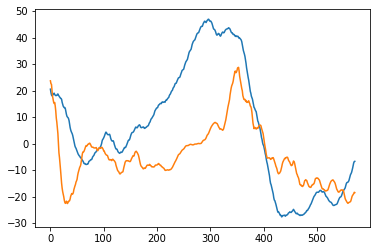

In [146]:
plt.plot(pre)

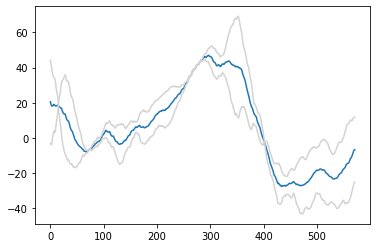

In [55]:
plt.plot(pre[:,0])
plt.plot(pre[:,0] + pre[:,1], c='lightgrey')
plt.plot(pre[:,0] - pre[:,1], c='lightgrey')

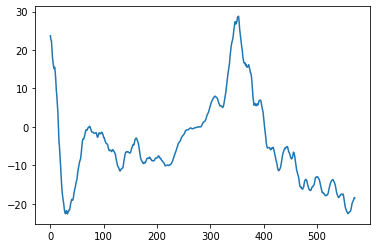

In [56]:
plt.plot(pre[:,1])

In [35]:
m4.fit_multiple(ds.dataset, suffix=suffixe)  # ds_nn
m4.print_histories()
m4.predict_multiple(ds.dataset)  # ds_nn
m4.save_prediction()

Fitting...


TypeError: 'NoneType' object is not callable

# --------------------------------------

In [11]:
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras import layers
# from utils import simulate, plot_L96_2D, dt, rmse, Periodic1DPadding

In [12]:
def rmse (xref, xest, axis=(1,),norm=True):
    """Compute the root mean square. If norm is true (default), the error is normalize by 2 standard deviation."""
    rmse_ret = np.sqrt(np.mean(np.square(xref-xest),axis=axis))
    if norm:
        rmse_ret /= 2*np.std(xref,axis=axis)
    return rmse_ret

class Periodic1DPadding(keras.layers.Layer):
    """Add a periodic padding to the output of the layer
    (no trainable parameters in this layer)
    # Arguments
        padding_size: tuple giving the padding size (left, right)
    # Output Shape
        input_shape+left+right
    """
    def __init__ (self, padding_size, **kwargs):
        super(Periodic1DPadding, self).__init__(**kwargs)
        if isinstance(padding_size, int):
            padding_size = (padding_size, padding_size)
        self.padding_size = tuple(padding_size)

    def compute_output_shape( self, input_shape ):
        space = input_shape[1:-1]
        if len(space) != 1:
            raise ValueError ('Input shape should be 1D with channel at last')
        new_dim = space[0] + np.sum(self.padding_size)
        return (input_shape[0],new_dim,input_shape[-1])



    def build( self , input_shape):
        super(Periodic1DPadding,self).build(input_shape)

    def call( self, inputs ):
        vleft, vright = self.padding_size
        leftborder = inputs[:, -vleft:, :]
        rigthborder = inputs[:, :vright, :]
        return tf.concat([leftborder, inputs, rigthborder], axis=-2)

In [38]:
M = 8  # npca

stoch = True  # False # True #To predict the standard deviation
norm_input = True #Standardization of the input vector
nhid1 = 60 # Number of filters in the first hidden layer
nhid2 = 40 # Number of filters in the second hiddent layer
filter1 = 5 # Filter size for the first layer
filter2 = 1 # Filter size of the second layer
epochs = 40 # Number of epochs during optimization
optimizer = 'Adam'# Optimizer used for the training
var = True



In [39]:
if var:
    scale_std = np.sqrt
    scale_var = lambda x:x
else:
    scale_std = lambda x:x
    scale_var = np.square

In [40]:
if norm_input:
    mean_ = np.mean(ds.dataset['ytrain'],axis=(0,1),keepdims=True)
    std_= np.std(ds.dataset['ytrain'],axis=(0,1), keepdims=True)
    norm = lambda x: (x-mean_)/std_
    denorm = lambda x: x*std_ + mean_
else:
    norm = lambda x: x
    denorm = lambda x: x

In [119]:
# train CNN for uncertainty and mean



inputs = keras.Input(shape=(M,1))
border= (filter1//2+filter2//2)
lay = Periodic1DPadding(padding_size=border)(inputs)
lay = layers.Conv1D(nhid1, filter1, activation='tanh')(lay)
lay = layers.Conv1D(nhid2, filter2, activation='tanh')(lay)
outputs = layers.Conv1D(1,1)(lay)
nn_model_det = keras.Model(inputs=inputs, outputs=outputs, name='deterministic_L96')
nn_model_det.compile(optimizer=optimizer, loss='mse')
nn_model_det.summary()



Model: "deterministic_L96"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 8, 1)]            0         
                                                                 
 periodic1d_padding_3 (Perio  (None, 12, 1)            0         
 dic1DPadding)                                                   
                                                                 
 conv1d_20 (Conv1D)          (None, 8, 60)             360       
                                                                 
 conv1d_21 (Conv1D)          (None, 8, 40)             2440      
                                                                 
 conv1d_22 (Conv1D)          (None, 8, 1)              41        
                                                                 
Total params: 2,841
Trainable params: 2,841
Non-trainable params: 0
_______________________________________________

In [92]:
ds.dataset['Xtrain'].shape

(1859, 12, 28)

In [52]:
norm(ds.dataset['Xtrain'][:,0:1,:]).shape

(1859, 1, 28)

In [60]:
ds.dataset['ytrain'][:,0:1].shape

(1859, 1)

In [54]:
xtrain = norm(ds.dataset['Xtrain'][:,0:1,:]).reshape((1859,28,1))

In [56]:
xtrain.shape

(1859, 28, 1)

In [122]:
# train deterministic
history_d = nn_model_det.fit(norm(ds.dataset['ytrain']),ds.dataset['ytrain'], 
                             validation_data=(norm(ds.dataset['yval']),ds.dataset['yval']),epochs=epochs)

# history_d = nn_model_det.fit(xtrain, ds.dataset['ytrain'][:,0:1], 
#                              validation_data=(norm(ds.dataset['Xval'][:,0,:]),ds.dataset['yval']),epochs=epochs)


Epoch 1/40
59/59 [==============================] - 1s 4ms/step - loss: 434.0309 - val_loss: 154.0822
Epoch 2/40
59/59 [==============================] - 0s 3ms/step - loss: 176.5549 - val_loss: 101.4061
Epoch 3/40
59/59 [==============================] - 0s 3ms/step - loss: 123.5206 - val_loss: 75.6237
Epoch 4/40
59/59 [==============================] - 0s 3ms/step - loss: 93.7820 - val_loss: 61.3797
Epoch 5/40
59/59 [==============================] - 0s 2ms/step - loss: 76.3273 - val_loss: 51.5779
Epoch 6/40
59/59 [==============================] - 0s 3ms/step - loss: 65.3176 - val_loss: 44.9862
Epoch 7/40
59/59 [==============================] - 0s 3ms/step - loss: 57.7241 - val_loss: 40.4752
Epoch 8/40
59/59 [==============================] - 0s 3ms/step - loss: 51.7761 - val_loss: 35.7243
Epoch 9/40
59/59 [==============================] - 0s 3ms/step - loss: 47.0700 - val_loss: 32.9977
Epoch 10/40
59/59 [==============================] - 0s 2ms/step - loss: 43.2621 - val_loss: 29

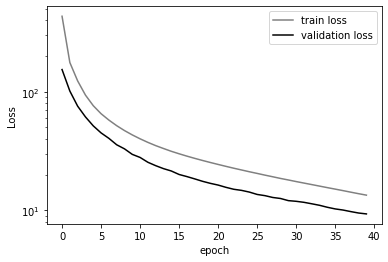

In [123]:
fig, ax = plt.subplots()
ax.semilogy(history_d.history['loss'],color='gray',label='train loss')
ax.semilogy(history_d.history['val_loss'],color='black',label='validation loss')
ax.legend()
ax.set_xlabel('epoch');
ax.set_ylabel('Loss');

In [41]:
def loss_mle_tfp(y_true, y_pred):
    mean_true = y_true
    mean_pred, std_pred = y_pred[...,0], y_pred[...,1]
    norm_dist = tfp.distributions.Normal(loc = mean_pred, scale = std_pred)
    loss = - norm_dist . log_prob ( y_true)
    loss = tf.reduce_mean(loss, -1)
    return loss

In [42]:
if stoch:
    inputs = keras.Input(shape=(M,1))
    border= (filter1//2+filter2//2)
    lay = Periodic1DPadding(padding_size=border)(inputs)
    lay = layers.Conv1D(nhid1, filter1, activation='tanh')(lay)
    lay = layers.Conv1D(nhid2, filter2, activation='tanh')(lay)
    mu = layers.Conv1D(1,1)(lay)
    var = layers.Conv1D(1,1, activation='exponential')(lay)
    outputs = layers.Concatenate(name='output')([mu, var])
    
    nn_model_gauss = keras.Model(inputs=inputs, outputs=outputs, name='gaussian_L96')
    #Need a special loss


    nn_model_gauss.compile(optimizer=optimizer, loss=loss_mle_tfp)
    nn_model_gauss.summary()


Model: "gaussian_L96"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 8, 1)]       0           []                               
                                                                                                  
 periodic1d_padding_2 (Periodic  (None, 12, 1)       0           ['input_3[0][0]']                
 1DPadding)                                                                                       
                                                                                                  
 conv1d_16 (Conv1D)             (None, 8, 60)        360         ['periodic1d_padding_2[0][0]']   
                                                                                                  
 conv1d_17 (Conv1D)             (None, 8, 40)        2440        ['conv1d_16[0][0]']   

In [18]:
import tensorflow_probability as tfp

In [20]:
ds.dataset['ytrain'].shape

(1859, 8)

In [21]:
xtrain = ds.dataset['ytrain'][0:-1]
ytrain = ds.dataset['ytrain'][1:]

In [29]:
xval = ds.dataset['yval'][0:-1]
yval = ds.dataset['yval'][1:]

In [114]:
if stoch:
    history_s = nn_model_gauss.fit(norm(xtrain), ytrain
                                   , validation_data=(norm(xval), yval),epochs=epochs)

Epoch 1/40
59/59 [==============================] - 0s 3ms/step - loss: 4.6512 - val_loss: 4.5314
Epoch 2/40
59/59 [==============================] - 0s 2ms/step - loss: 4.6497 - val_loss: 4.5300
Epoch 3/40
59/59 [==============================] - 0s 2ms/step - loss: 4.6483 - val_loss: 4.5337
Epoch 4/40
59/59 [==============================] - 0s 2ms/step - loss: 4.6472 - val_loss: 4.5326
Epoch 5/40
59/59 [==============================] - 0s 2ms/step - loss: 4.6457 - val_loss: 4.5274
Epoch 6/40
59/59 [==============================] - 0s 2ms/step - loss: 4.6438 - val_loss: 4.5242
Epoch 7/40
59/59 [==============================] - 0s 2ms/step - loss: 4.6426 - val_loss: 4.5220
Epoch 8/40
59/59 [==============================] - 0s 2ms/step - loss: 4.6411 - val_loss: 4.5258
Epoch 9/40
59/59 [==============================] - 0s 2ms/step - loss: 4.6393 - val_loss: 4.5230
Epoch 10/40
59/59 [==============================] - 0s 2ms/step - loss: 4.6374 - val_loss: 4.5185
Epoch 11/40
59/59 [

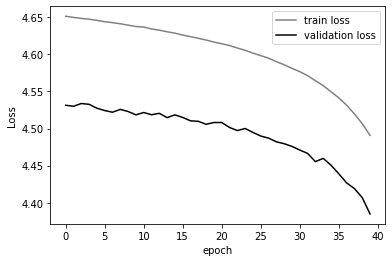

In [115]:
fig, ax = plt.subplots()
ax.plot(history_s.history['loss'],color='gray',label='train loss')
ax.plot(history_s.history['val_loss'],color='black',label='validation loss')
ax.legend()
ax.set_xlabel('epoch');
ax.set_ylabel('Loss');

In [71]:
ds.dataset['y']

(2860, 8)

In [124]:
ynn_det = nn_model_det.predict(norm(ds.dataset['y']))
if stoch:
    ynn_sto = nn_model_gauss.predict(norm(ds.dataset['y']))

90/90 [==============================] - 0s 1ms/step


In [125]:
ynn_det.shape

(2860, 8, 1)

In [49]:
ynn_sto.shape

(572, 8, 2)

In [87]:
ds.dataset['y'][:,0]

(2860,)

In [140]:
ds.dataset['y'][:,ipca]
ynn_det.shape

(2860, 8, 1)

In [141]:
ds.dataset['y'][:,ipca] + ynn_det[:,ipca,0]

array([ 44.7656  ,  43.706726,  43.424923, ..., -83.71158 , -83.51171 ,
       -83.46364 ], dtype=float32)

In [167]:
std_det = ds.dataset['y'][:,:] - ynn_det[:,:,0]

In [175]:
std_d = np.sqrt(np.mean(np.square(ynn_det.squeeze() - ds.dataset['y']), axis=0))

In [177]:
std_d

array([5.7614303, 5.6105514, 2.250147 , 2.9420404, 2.1858318, 1.8497249,
       2.2554154, 2.9666245], dtype=float32)

In [149]:
std.shape

(2860, 8)

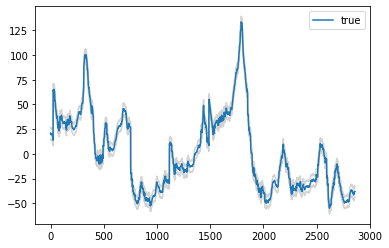

In [186]:
ipca = 0
# plt.plot(ynn_det[:,ipca]-ynn_det[:,ipca], c='lightgrey', alpha=0.8)
# plt.plot(ynn_det[:,ipca]+ynn_det[:,ipca], c='lightgrey', alpha=0.8)
plt.plot(ds.dataset['y'][:,ipca] + std_d[ipca],c='lightgrey')
plt.plot(ds.dataset['y'][:,ipca] - std_d[ipca],c='lightgrey')


plt.plot(ds.dataset['y'][:,ipca], label='true')
plt.legend()

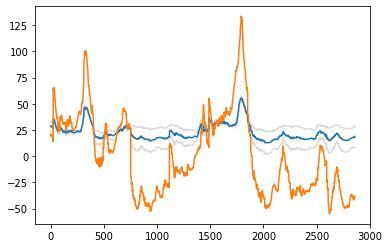

In [187]:
ipca = 0
plt.plot(ynn_sto[:,ipca,1]-ynn_sto[:,ipca,0], c='lightgrey', alpha=0.8)
plt.plot(ynn_sto[:,ipca,1]+ynn_sto[:,ipca,0], c='lightgrey', alpha=0.8)
plt.plot(ynn_sto[:,ipca,1])

plt.plot(ds.dataset['y'][:,0])

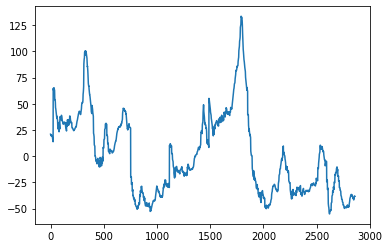

In [92]:
plt.plot(ds.dataset['y'][:,0])

In [97]:
pr = denorm(ynn_sto[:,:,0])

In [98]:
pr.shape

(2860, 8)

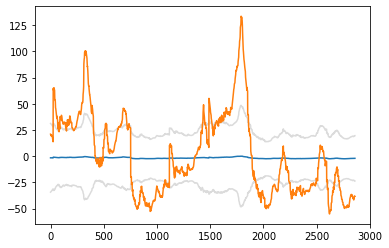

In [118]:
plt.plot(ynn_sto[:,ipca,0])
plt.plot(ynn_sto[:,ipca,0]+ ynn_sto[:,0,1], c='lightgrey', alpha=0.8)
plt.plot(ynn_sto[:,ipca,0]- ynn_sto[:,0,1], c='lightgrey', alpha=0.8)

plt.plot(ds.dataset['y'][:,0])

# --------------------------------------

In [ ]:
# a simple way

In [80]:
le_x.shape

(2860, 12, 28)

In [81]:
def predict_with_uncertainty(model, x, n_iter=100):
    results = np.zeros((n_iter, x.shape[0], 1))
    pert = 0.1
    for i in range(n_iter):
        noise = pert * np.random.randn(x.shape[0], x.shape[1], x.shape[2])
        results[i] = model.predict(x+noise, batch_size=batch_size)
    prediction = results.mean(axis=0)
    uncertainty = results.std(axis=0)
    return prediction, uncertainty

In [64]:
le_model = m4.models['pc0']
le_x = np.concatenate((ds.dataset["Xtest"], ds.dataset["Xval"], ds.dataset["Xtrain"]))

In [67]:
batch_size = m4.batch_size

In [82]:
prediction, uncertainty = predict_with_uncertainty(le_model, le_x, n_iter=10)

715/715 [==============================] - 1s 977us/step


In [70]:
prediction.shape

(2860, 1)

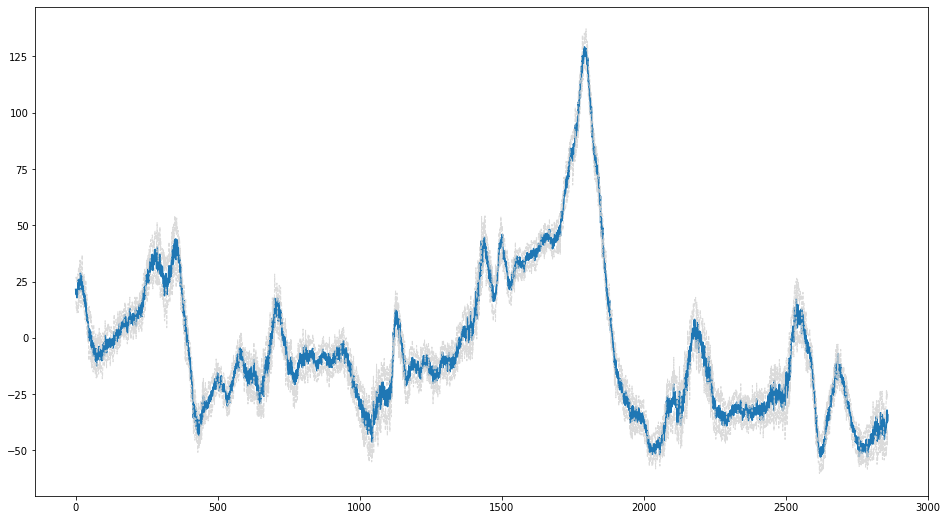

In [91]:
fig, ax = plt.subplots(figsize=(16,9))

plt.plot(prediction, lw=2)
plt.plot(prediction+uncertainty, ls='--', lw=1, c='lightgray', alpha=0.8)
plt.plot(prediction-uncertainty, ls='--', lw=1, c='lightgray', alpha=0.8)

# --------------------------------------

In [ ]:
# m4.save_model()
m4.save_model_weights()

ofile = f'{m4.type}_ypred.png'
mdl_ypred_PCA.draw(m4, odir=m4.rootdir+m4.fig_dir, savefig=True, showfig=False, ofile=ofile)